In [1]:
# Imports
import cv2
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import date2num, SecondLocator, DateFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path

import aeon
import aeon.io.api as api
from aeon.io import reader, video
from aeon.schema.dataset import exp02
from aeon.analysis.utils import visits, distancetravelled

import inference
import learning
import torch

In [2]:
# Get relevant time periods
# Run Time: 13 s

# Short, multianimal test sessions
#root = [Path("/ceph/aeon/aeon/data/raw/AEON3/multianimal-test")]

# Long, individual session
root = [Path("/ceph/aeon/aeon/data/raw/AEON2/experiment0.2")]

# Ensure root exists
if not np.all([path.exists() for path in root]):
    print("Cannot find root paths. Check path names or connection.")

In [3]:
!ls /ceph/aeon

aeon			 aeon_transfer.log  rmhzbm0  test2
aeon_transfer_final.log  db_dumps	    test


In [6]:
Exp02Summary = api.load(root, exp02.Metadata).metadata[0].toDict()
Patch_Pos = [device['Regions']['ArrayOfPoint'] for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]
Patch_Thre = [int(device['ThresholdValue']) for device in Exp02Summary['Devices'] if device['Name'].startswith('ActivityPatch')]

In [4]:
subject_events = api.load(root, exp02.ExperimentalMetadata.SubjectState)
sessions = visits(subject_events[subject_events.id.str.startswith("BAA-")])
#sessions = sessions[sessions.duration > pd.Timedelta("24 hours")]

display(sessions)

,id,weight_enter,weight_exit,enter,exit,duration
0,BAA-1100700,26.40,28.10,2022-02-23 14:21:25.550300121,2022-02-25 16:00:50.076419830,2 days 01:39:24.526119709
1,BAA-1100700,25.50,28.45,2022-03-02 13:47:43.875840187,2022-03-02 18:14:47.459969997,0 days 04:27:03.584129810
2,BAA-1100700,24.55,24.55,2022-03-04 14:00:01.818980217,2022-03-04 14:00:49.259260178,0 days 00:00:47.440279961
3,BAA-1100700,24.55,28.27,2022-03-04 14:04:16.610499859,2022-03-04 19:24:41.778140068,0 days 05:20:25.167640209
4,BAA-1100700,26.30,26.30,2022-03-15 12:40:36.282139778,2022-03-15 15:56:55.801119804,0 days 03:16:19.518980026
5,BAA-1100700,27.60,28.80,2022-03-16 15:06:37.790820122,2022-03-16 16:44:50.910079956,0 days 01:38:13.119259834
6,BAA-1100700,25.50,28.50,2022-03-17 15:56:35.478690147,2022-03-17 17:41:48.763070107,0 days 01:45:13.284379960
7,BAA-1100700,24.30,26.80,2022-03-23 14:47:58.253819942,2022-03-24 14:08:54.449150085,0 days 23:20:56.195330143
8,BAA-1100699,26.75,29.00,2022-03-29 13:11:37.277699947,2022-04-04 09:16:51.086110115,5 days 20:05:13.808410168
9,BAA-1100701,27.00,26.70,2022-04-04 13:59:13.352029800,2022-04-04 15:19:41.652349949,0 days 01:20:28.300320149


In [5]:
# Load mice 15 - BAA-1100703
# Run time: 3 min 17 s

# Set time range to get data from based on one of the above "sessions"
start, end = pd.Timestamp("2022-05-25 09:00:00"), pd.Timestamp("2022-05-25 21:00:00")

# Load position data
mouse_pos = api.load(root, exp02.CameraTop.Position, start=start, end=end)
display(mouse_pos)

,x,y,angle,major,minor,area,id
time,,,,,,,
2022-05-25 09:00:00.018559933,1128.485352,377.081421,1.400470,40.002785,15.242581,632.5,0.0
2022-05-25 09:00:00.038527966,1128.333374,374.231598,1.367503,39.120983,15.174746,616.0,0.0
2022-05-25 09:00:00.058559895,1127.752686,371.373230,1.375104,38.317028,15.396613,610.0,0.0
2022-05-25 09:00:00.078527927,1127.116333,368.639618,1.366908,38.901909,15.832431,635.0,0.0
2022-05-25 09:00:00.098559856,1126.835571,366.416992,1.389153,38.970348,16.226841,649.5,0.0
...,...,...,...,...,...,...,...
2022-05-25 20:59:59.911808014,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
2022-05-25 20:59:59.931776047,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0
2022-05-25 20:59:59.951807976,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0


In [6]:
pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
aeon.load(root, exp02.ExperimentMetadata.Messagelog, start = start, end = end)

,_typ,dtype,ndim
time,,,


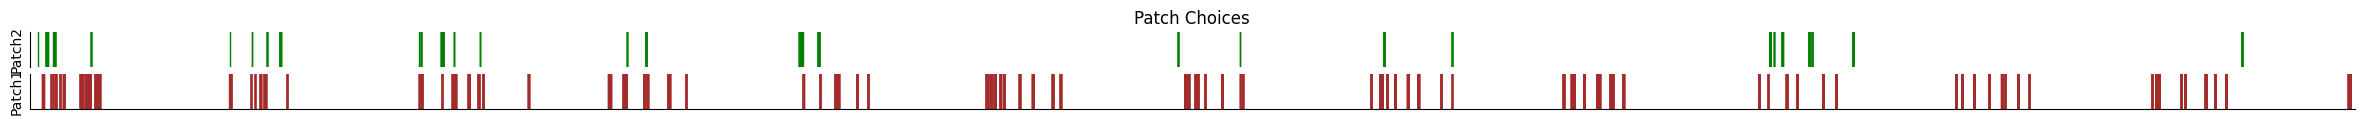

In [11]:
start, end = pd.Timestamp("2022-05-25 09:00:00"), pd.Timestamp("2022-06-06 08:00:00")

pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=start, end=end)
pellets_patch2 = api.load(root, exp02.Patch2.DeliverPellet, start=start, end=end)
#aeon.load(root, exp02.ExperimentMetadata.Messagelog, start = start, end = end)

fig, axs = plt.subplots(2, 1, figsize=(30, 1), sharex=True)

for pellet in pellets_patch1.itertuples():
    forage_time = pellet.Index
    axs[0].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_title('Patch Choices')
axs[0].set_ylabel('Patch2')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)
axs[0].set_xlim(start, end)

for pellet in pellets_patch2.itertuples():
    forage_time = pellet.Index
    axs[1].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
axs[1].set_yticks([])  
axs[1].set_facecolor('white')  
axs[1].set_ylabel('Patch1')
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].set_xlim(start, end)

plt.show()

# Positions

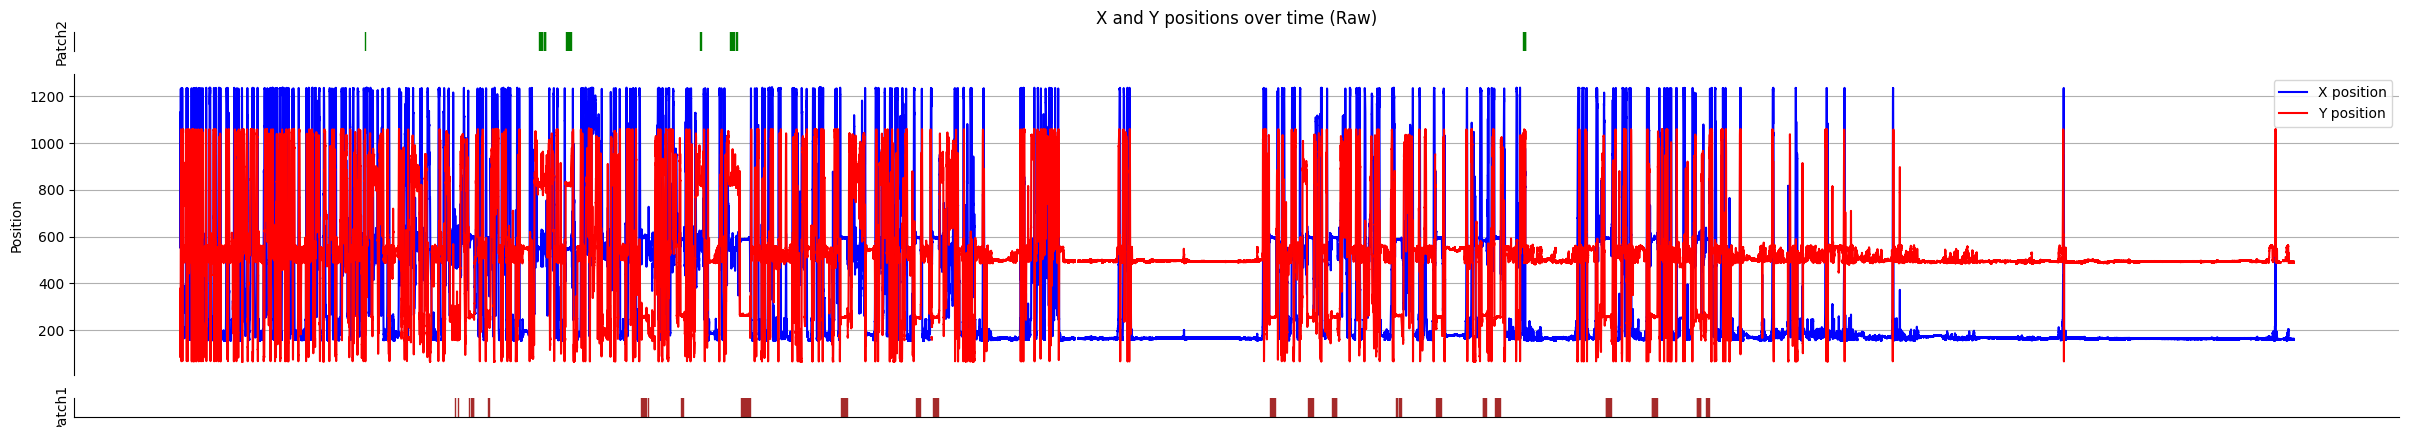

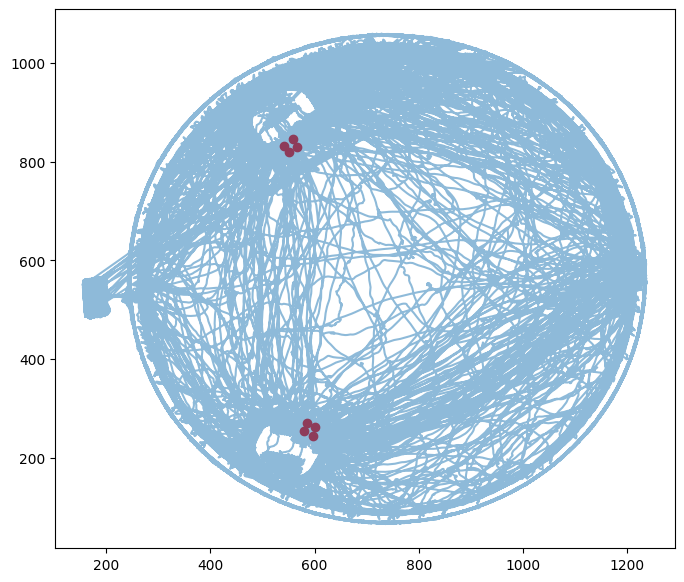

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(30, 5), gridspec_kw={'height_ratios': [1, 16, 1]}, sharex=True)


for pellet in pellets_patch1.itertuples():
    forage_time = pellet.Index
    axs[0].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_title('X and Y positions over time (Raw)')
axs[0].set_ylabel('Patch2')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)


axs[1].plot(mouse_pos.index, mouse_pos.x, label='X position', color='blue')
axs[1].plot(mouse_pos.index, mouse_pos.y, label='Y position', color='red')
axs[1].set_xticks([])
axs[1].set_ylabel('Position')
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

for pellet in pellets_patch2.itertuples():
    forage_time = pellet.Index
    axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('Patch1')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.show()

fig, ax = plt.subplots(1, 1, figsize = (8,7))
ax.plot(mouse_pos.x, mouse_pos.y, alpha=0.5)

for patch in Patch_Pos:
    patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
    for pos in patch_pos: ax.scatter(pos[0], pos[1], color = 'red')
    
plt.show()


# Relation with Patches

In [7]:
patch_center = []
for patch in Patch_Pos: 
    patch_pos = [np.array([int(pos['X']), int(pos['Y'])]) for pos in patch]
    patch_center.append(np.mean(patch_pos, axis = 0))
patch_center

[array([554., 832.]), array([590.25, 256.75])]

In [8]:
dis_1, dis_2 = [], []

for i in range(len(mouse_pos.index)):
    dis_1.append(np.sqrt((mouse_pos.x[i] - patch_center[0][0])**2 + (mouse_pos.y[i] - patch_center[0][1])**2))
    dis_2.append(np.sqrt((mouse_pos.x[i] - patch_center[1][0])**2 + (mouse_pos.y[i] - patch_center[1][1])**2))

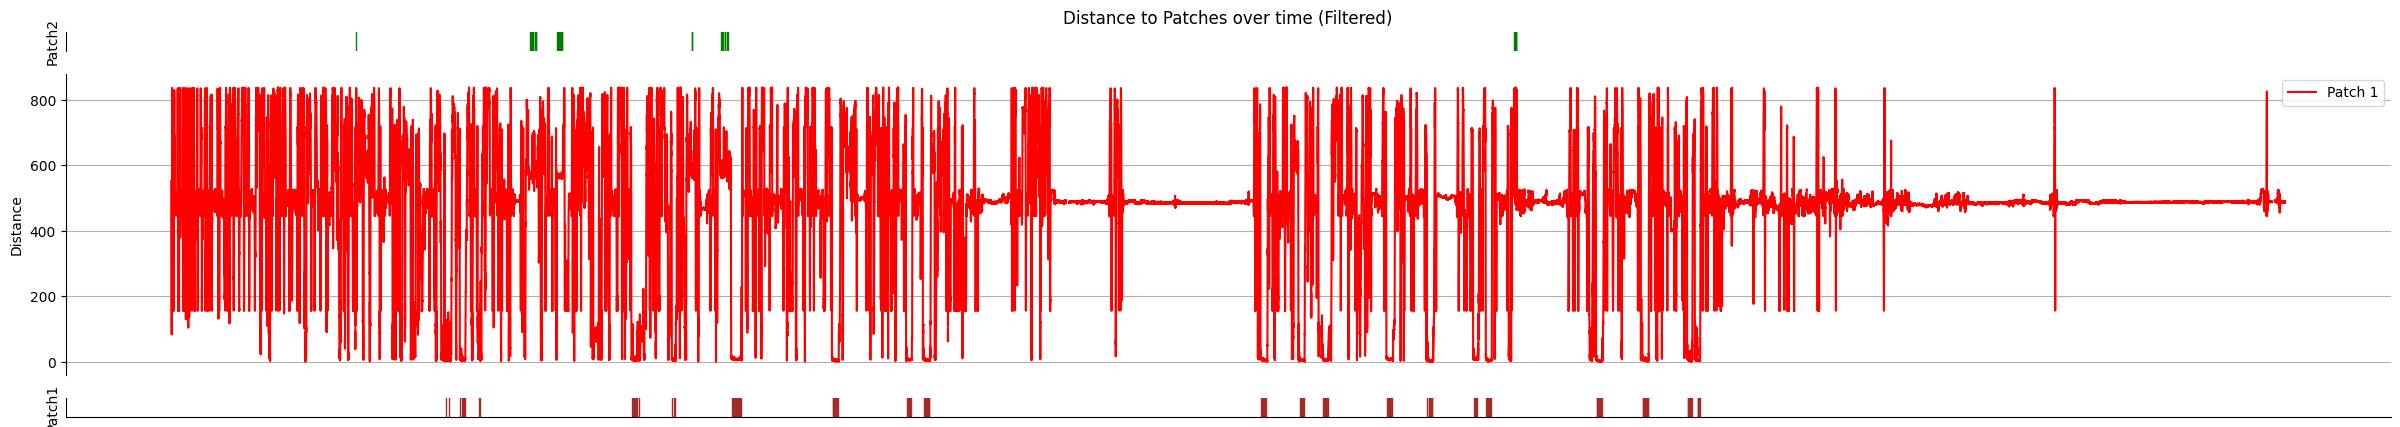

In [14]:
%matplotlib inline
fig, axs = plt.subplots(3, 1, figsize=(30, 5), gridspec_kw={'height_ratios': [1, 16, 1]}, sharex=True)


for pellet in pellets_patch1.itertuples():
    forage_time = pellet.Index
    axs[0].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_title('Distance to Patches over time (Filtered)')
axs[0].set_ylabel('Patch2')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)


#axs[1].plot(mouse_pos.index, dis_1, label='Patch 2', color='blue')
axs[1].plot(mouse_pos.index, dis_2, label='Patch 1', color='red')
axs[1].set_xticks([])
axs[1].set_ylabel('Distance')
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

for pellet in pellets_patch2.itertuples():
    forage_time = pellet.Index
    axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('Patch1')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.show()


# Filtering: Long Period

In [15]:
# Filtering
obs = np.transpose(mouse_pos[["x", "y"]].to_numpy())
pos_x0, pos_y0 = obs[0, 0], obs[1, 0]

vel_x0, vel_y0 = 0.0, 0.0
acc_x0, acc_y0 = 0.0, 0.0

sigma_a = 0.1

sigma_x = 1
sigma_y = 1

sqrt_diag_V0_value = 1e-3

date_times = pd.to_datetime(mouse_pos.index)
dt = (date_times[1]-date_times[0]).total_seconds()

B = np.array([[1, dt, .5*dt**2, 0, 0, 0],
               [0, 1, dt, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, dt, .5*dt**2],
               [0, 0, 0, 0, 1, dt],
               [0, 0, 0, 0, 0, 1]],
              dtype=np.double)

Qt = np.array([[dt**4/4, dt**3/2, dt**2/2, 0, 0, 0],
               [dt**3/2, dt**2,   dt,      0, 0, 0],
               [dt**2/2, dt,      1,       0, 0, 0],
               [0, 0, 0, dt**4/4, dt**3/2, dt**2/2],
               [0, 0, 0, dt**3/2, dt**2,   dt],
               [0, 0, 0, dt**2/2, dt,      1]],
              dtype=np.double)
Q = sigma_a**2 * Qt

m0 = np.array([[obs[0, 0], 0, 0, obs[1, 0], 0, 0]], dtype=np.double).T
V0 = np.diag(np.ones(len(m0))*sqrt_diag_V0_value**2)


Z = np.array([[1, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0]],
              dtype=np.double)

R = np.diag([sigma_x**2, sigma_y**2])

onlineKF = inference.OnlineKalmanFilter(B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)

filtered_means = np.empty((6, 1, obs.shape[1]), dtype=np.double)
filtered_covs = np.empty((6, 6, obs.shape[1]), dtype=np.double)

for i in range(obs.shape[1]):
    _, _ = onlineKF.predict()
    filtered_means[:, :, i], filtered_covs[:, :, i] = onlineKF.update(y=obs[:, i])

## Filtered Position

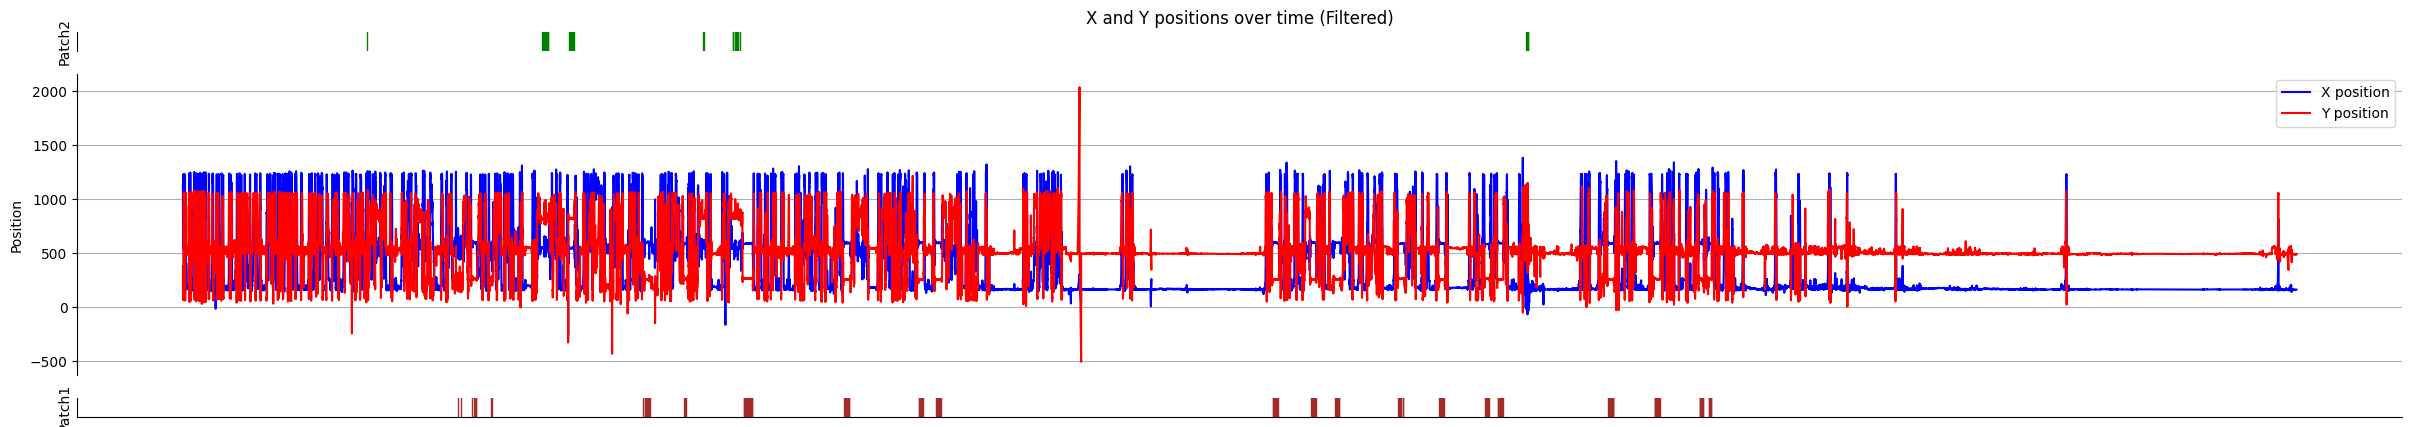

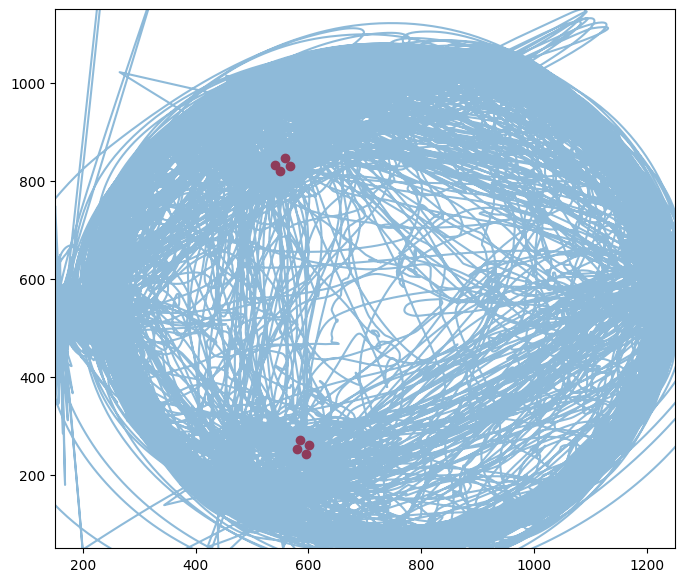

In [22]:
filter_mean_x = filtered_means[0, 0, :]
filter_mean_y = filtered_means[3, 0, :]
filter_std_x_y = np.sqrt(np.diagonal(a=filtered_covs, axis1=0, axis2=1))

filter_ci_x_upper = filter_mean_x + 1.96*filter_std_x_y[:, 0]
filter_ci_x_lower = filter_mean_x - 1.96*filter_std_x_y[:, 0]
filter_ci_y_upper = filter_mean_y + 1.96*filter_std_x_y[:, 3]
filter_ci_y_lower = filter_mean_y - 1.96*filter_std_x_y[:, 3]



fig, axs = plt.subplots(3, 1, figsize=(30, 5), gridspec_kw={'height_ratios': [1, 16, 1]}, sharex=True)


for pellet in pellets_patch1.itertuples():
    forage_time = pellet.Index
    axs[0].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_title('X and Y positions over time (Filtered)')
axs[0].set_ylabel('Patch2')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)


axs[1].plot(mouse_pos.index, filter_mean_x, label='X position', color='blue')
axs[1].plot(mouse_pos.index, filter_mean_y, label='Y position', color='red')
axs[1].set_xticks([])
axs[1].set_ylabel('Position')
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

for pellet in pellets_patch2.itertuples():
    forage_time = pellet.Index
    axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('Patch1')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.show()

xlim, ylim = (150, 1250), (50, 1150)
fig, ax = plt.subplots(1, 1, figsize = (8,7))
ax.plot(filter_mean_x, filter_mean_y, alpha=0.5)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

for patch in Patch_Pos:
    patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
    for pos in patch_pos: ax.scatter(pos[0], pos[1], color = 'red')
    
plt.show()


## Filtered Velocity

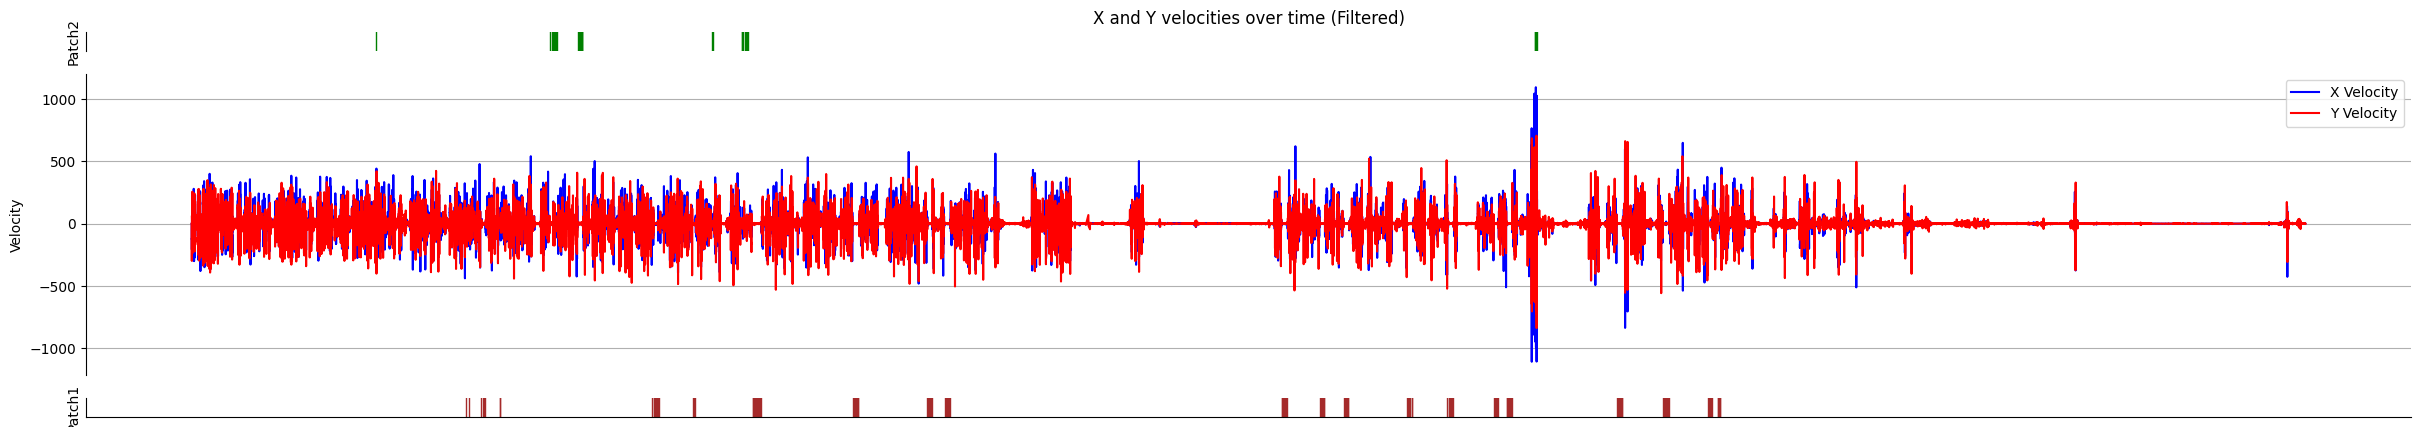

In [23]:
filter_mean_x = filtered_means[1, 0, :]
filter_mean_y = filtered_means[4, 0, :]
filter_std_x_y = np.sqrt(np.diagonal(a=filtered_covs, axis1=0, axis2=1))

filter_ci_x_upper = filter_mean_x + 1.96*filter_std_x_y[:, 1]
filter_ci_x_lower = filter_mean_x - 1.96*filter_std_x_y[:, 1]
filter_ci_y_upper = filter_mean_y + 1.96*filter_std_x_y[:, 4]
filter_ci_y_lower = filter_mean_y - 1.96*filter_std_x_y[:, 4]



fig, axs = plt.subplots(3, 1, figsize=(30, 5), gridspec_kw={'height_ratios': [1, 16, 1]}, sharex=True)


for pellet in pellets_patch1.itertuples():
    forage_time = pellet.Index
    axs[0].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_title('X and Y velocities over time (Filtered)')
axs[0].set_ylabel('Patch2')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)


axs[1].plot(mouse_pos.index, filter_mean_x, label='X Velocity', color='blue')
axs[1].plot(mouse_pos.index, filter_mean_y, label='Y Velocity', color='red')
axs[1].set_xticks([])
axs[1].set_ylabel('Velocity')
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

for pellet in pellets_patch2.itertuples():
    forage_time = pellet.Index
    axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('Patch1')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.show()


## Filtered Acc.

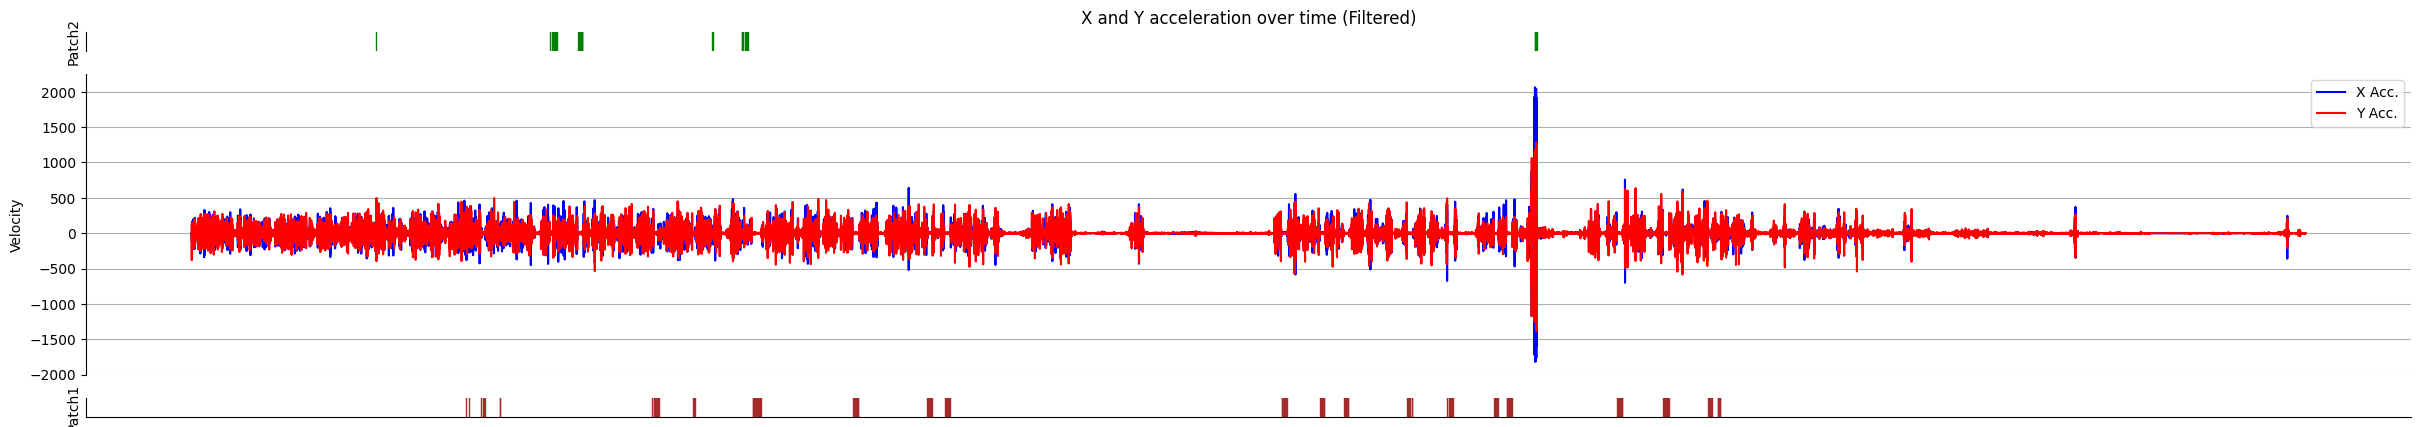

In [19]:
filter_mean_x = filtered_means[2, 0, :]
filter_mean_y = filtered_means[5, 0, :]
filter_std_x_y = np.sqrt(np.diagonal(a=filtered_covs, axis1=0, axis2=1))

filter_ci_x_upper = filter_mean_x + 1.96*filter_std_x_y[:, 2]
filter_ci_x_lower = filter_mean_x - 1.96*filter_std_x_y[:, 2]
filter_ci_y_upper = filter_mean_y + 1.96*filter_std_x_y[:, 5]
filter_ci_y_lower = filter_mean_y - 1.96*filter_std_x_y[:, 5]



fig, axs = plt.subplots(3, 1, figsize=(30, 5), gridspec_kw={'height_ratios': [1, 16, 1]}, sharex=True)


for pellet in pellets_patch1.itertuples():
    forage_time = pellet.Index
    axs[0].axvline(pd.Timestamp(forage_time), color='green', linewidth=1)
axs[0].set_xticks([]) 
axs[0].set_yticks([]) 
axs[0].set_facecolor('white') 
axs[0].set_title('X and Y acceleration over time (Filtered)')
axs[0].set_ylabel('Patch2')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)
axs[0].spines['bottom'].set_visible(False)


axs[1].plot(mouse_pos.index, filter_mean_x, label='X Acc.', color='blue')
axs[1].plot(mouse_pos.index, filter_mean_y, label='Y Acc.', color='red')
axs[1].set_xticks([])
axs[1].set_ylabel('Velocity')
axs[1].legend(loc = 'upper right')
axs[1].grid(True)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)

for pellet in pellets_patch2.itertuples():
    forage_time = pellet.Index
    axs[2].axvline(pd.Timestamp(forage_time), color='brown', linewidth=1)
axs[2].set_yticks([])  
axs[2].set_facecolor('white')  
axs[2].set_ylabel('Patch1')
axs[2].spines['top'].set_visible(False)
axs[2].spines['right'].set_visible(False)

plt.show()


# Filtering: Short Period

In [9]:
# Create some plots
xlim, ylim = (150, 1250), (50, 1150)

# Plot _ hours of position activity
sub_start, sub_end = pd.Timestamp("2022-05-26 09:00:00"), pd.Timestamp("2022-05-26 10:00:00")
mouse_pos_sub = api.load(root, exp02.CameraTop.Position, start=sub_start, end=sub_end)

# Filtering
obs = np.transpose(mouse_pos_sub[["x", "y"]].to_numpy())
pos_x0, pos_y0 = obs[0, 0], obs[1, 0]

vel_x0, vel_y0 = 0.0, 0.0
acc_x0, acc_y0 = 0.0, 0.0

sigma_a = 0.1

sigma_x = 0.5
sigma_y = 0.5

sqrt_diag_V0_value = 1e-3

date_times = pd.to_datetime(mouse_pos.index)
dt = (date_times[1]-date_times[0]).total_seconds()

B = np.array([[1, dt, .5*dt**2, 0, 0, 0],
               [0, 1, dt, 0, 0, 0],
               [0, 0, 1, 0, 0, 0],
               [0, 0, 0, 1, dt, .5*dt**2],
               [0, 0, 0, 0, 1, dt],
               [0, 0, 0, 0, 0, 1]],
              dtype=np.double)

Qe = np.array([[dt**5/20, dt**4/8, dt**3/6, 0, 0, 0],
               [dt**4/8, dt**3/3,  dt**2/2, 0, 0, 0],
               [dt**3/6, dt**2/2,  dt,      0, 0, 0],
               [0, 0, 0,                    dt**5/20, dt**4/8, dt**3/6],
               [0, 0, 0,                    dt**4/8, dt**3/3,  dt**2/2],
               [0, 0, 0,                    dt**3/6, dt**2/2,  dt]],
              dtype=np.double)

Q = Qe*sigma_a

#Q = sigma_a**2 * Qt
Z = np.array([[1, 0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0, 0]],
              dtype=np.double)

m0 = np.array([[obs[0, 0], 0, 0, obs[1, 0], 0, 0]], dtype=np.double).T
V0 = np.diag(np.ones(len(m0))*sqrt_diag_V0_value**2)

R = np.diag([sigma_x**2, sigma_y**2])

onlineKF = inference.OnlineKalmanFilter(B=B, Q=Q, m0=m0, V0=V0, Z=Z, R=R)

filtered_means = np.empty((6, 1, obs.shape[1]), dtype=np.double)
filtered_covs = np.empty((6, 6, obs.shape[1]), dtype=np.double)

for i in range(obs.shape[1]):
    _, _ = onlineKF.predict()
    filtered_means[:, :, i], filtered_covs[:, :, i] = onlineKF.update(y=obs[:, i])

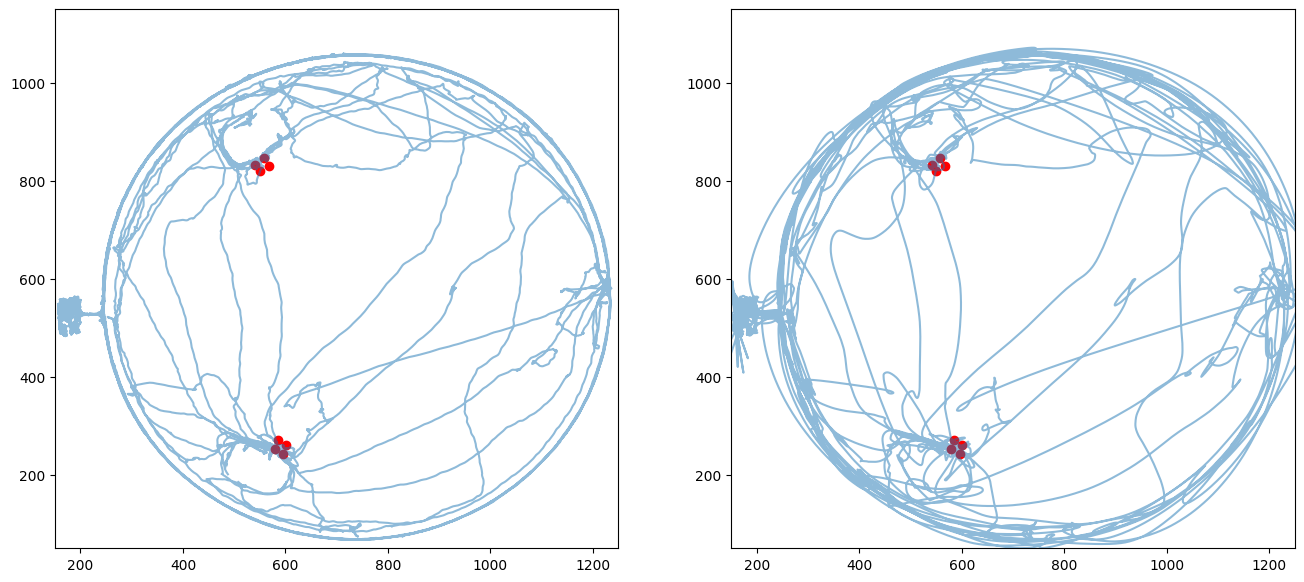

In [75]:
fig, axs = plt.subplots(1, 2, figsize = (16,7))
axs[0].plot(mouse_pos_sub.x, mouse_pos_sub.y, alpha=0.5)

for patch in Patch_Pos:
    patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
    for pos in patch_pos: axs[0].scatter(pos[0], pos[1], color = 'red')
axs[0].set_xlim(xlim)
axs[0].set_ylim(ylim)
    
filter_mean_x = filtered_means[0, 0, :]
filter_mean_y = filtered_means[3, 0, :]
filter_std_x_y = np.sqrt(np.diagonal(a=filtered_covs, axis1=0, axis2=1))

filter_ci_x_upper = filter_mean_x + 1.96*filter_std_x_y[:, 0]
filter_ci_x_lower = filter_mean_x - 1.96*filter_std_x_y[:, 0]
filter_ci_y_upper = filter_mean_y + 1.96*filter_std_x_y[:, 3]
filter_ci_y_lower = filter_mean_y - 1.96*filter_std_x_y[:, 3]

axs[1].plot(filter_mean_x, filter_mean_y, alpha=0.5)

for patch in Patch_Pos:
    patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
    for pos in patch_pos: axs[1].scatter(pos[0], pos[1], color = 'red')

axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)

plt.show()

In [48]:
# Learn parameters
pos_x0_manual, pos_y0_manual = obs[0, 0], obs[1, 0]
vel_x0_manual, vel_y0_manual = 0.0, 0.0
acc_x0_manual, acc_y0_manual = 0.0, 0.0

sigma_a_manual = 1e4
sigma_x_manual = 1e2
sigma_y_manual = 1e2
sqrt_diag_V0_value_manual = 1e-3

m0_manual = np.array([pos_x0_manual, vel_x0_manual, acc_x0_manual,
                      pos_y0_manual, vel_y0_manual, acc_y0_manual], dtype=np.double)
V0_manual = np.diag(np.ones(len(m0_manual))*sqrt_diag_V0_value_manual**2)
R_manual = np.diag([sigma_x_manual**2, sigma_y_manual**2])
Q_manual = Qe*sigma_a_manual

Q_learned, m0_learned, V0_learned, R_learned = [],[],[],[]
for i in range(16):
    y = obs[:, i*10800:min((i+1)*10800, len(obs[0]))]
    
    skip_estimation_sigma_a = False
    skip_estimation_R = False
    skip_estimation_m0 = False
    skip_estimation_V0 = False


    # LBFGS optimization algorithm: approximates the Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm using a limited amount of computer memory
    lbfgs_n_epochs = 75               ## The number of epochs for training
    lbfgs_max_iter = 2                ## Maximum number of iterations for the L-BFGS optimization algorithm in one epoch
    lbfgs_tolerance_grad = -1         ## Tolerance for stopping criterion with respect to gradients
    lbfgs_tolerance_change = 1e-3     ## A convergence criterion 
                                        ### The optimization will stop if the absolute value of the difference 
                                        ### in the loss between two consecutive iterations 
                                        ### is less than this value 
    lbfgs_lr = 0.01                   ## learning rate for the optimization. 
                                        ### A learning rate determines the step size at each iteration 
                                        ### while moving toward a minimum of the loss function

    lbfgs_tol = 1e-3
    Qe_reg_param_learned = 1e-2

    m0_torch = torch.from_numpy(m0_manual.copy())
    sqrt_diag_V0_torch = torch.DoubleTensor([sqrt_diag_V0_value_manual
                                            for i in range(len(m0_manual))])

    sqrt_diag_R_torch = torch.DoubleTensor([sigma_x_manual, sigma_y_manual])

    # Regularize Qe
    if Qe_reg_param_learned is not None:
        Qe_regularized_learned = Qe + Qe_reg_param_learned * np.eye(Qe.shape[0]) ## np.eye: identity matrix
        # Tikhonov or Ridge regularization. 
        # This regularization tends to ensure that the matrix remains positive definite and stabilizes its inversion if used in subsequent calculations
    else:
        Qe_regularized_learned = Qe
        
    y_torch = torch.from_numpy(y.astype(np.double))
    B_torch = torch.from_numpy(B.astype(np.double))
    Qe_regularized_learned_torch = torch.from_numpy(Qe_regularized_learned.astype(np.double))
    Z_torch = torch.from_numpy(Z.astype(np.double))

    vars_to_estimate = {} # Determine which parameters of a Kalman filter should be estimated
    if skip_estimation_sigma_a: vars_to_estimate["sigma_a"] = False
    else:                       vars_to_estimate["sigma_a"] = True

    if skip_estimation_R: vars_to_estimate["sqrt_diag_R"], vars_to_estimate["R"] = False, False
    else:
                        vars_to_estimate["sqrt_diag_R"], vars_to_estimate["R"] = True, True

    if skip_estimation_m0: vars_to_estimate["m0"] = False
    else:                  vars_to_estimate["m0"] = True

    if skip_estimation_V0: vars_to_estimate["sqrt_diag_V0"], vars_to_estimate["V0"] = False, False
    else:                  vars_to_estimate["sqrt_diag_V0"], vars_to_estimate["V0"] = True, True

    optim_res_learned = learning.torch_lbfgs_optimize_SS_tracking_diagV0(
        y=y_torch, B=B_torch, sigma_a0=sigma_a_manual,
        Qe=Qe_regularized_learned_torch, Z=Z_torch, sqrt_diag_R_0=sqrt_diag_R_torch, m0_0=m0_torch,
        sqrt_diag_V0_0=sqrt_diag_V0_torch, max_iter=lbfgs_max_iter, lr=lbfgs_lr,
        vars_to_estimate=vars_to_estimate, tolerance_grad=lbfgs_tolerance_grad,
        tolerance_change=lbfgs_tolerance_change, n_epochs=lbfgs_n_epochs,
        tol=lbfgs_tol)
    
    Q_learned.append(optim_res_learned["estimates"]["sigma_a"].item()**2*Qe)
    m0_learned.append(optim_res_learned["estimates"]["m0"].numpy())
    V0_learned.append(np.diag(optim_res_learned["estimates"]["sqrt_diag_V0"].numpy()**2))
    R_learned.append(np.diag(optim_res_learned["estimates"]["sqrt_diag_R"].numpy()**2))

np.savez("20231113.npz", Q = Q_learned, m = m0_learned, V = V0_learned, R = R_learned)

/nfs/nhome/live/zimol/ProjectAeon/aeon_mecha/inference.py:225: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3614.)
  innov.T @ Sinv @ innov


--------------------------------------------------------------------------------
epoch: 0
likelihood: -169723.74243658627
sigma_a: 
tensor([9848.2178], requires_grad=True)
sqrt_diag_R: 
tensor([-50.2491, -50.2492], dtype=torch.float64, requires_grad=True)
m0: 
tensor([1.6535e+02, 1.6374e-07, 1.3436e-08, 4.8929e+02, 3.4167e-07, 1.0750e-08],
       dtype=torch.float64, requires_grad=True)
sqrt_diag_V0: 
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010], dtype=torch.float64,
       requires_grad=True)
--------------------------------------------------------------------------------
epoch: 0
likelihood: -169734.5038383954
sigma_a: 
tensor([9784.0010], requires_grad=True)
sqrt_diag_R: 
tensor([-113.6791, -113.6792], dtype=torch.float64, requires_grad=True)
m0: 
tensor([ 1.6535e+02,  7.4401e-07,  2.0389e-08,  4.8929e+02, -4.4430e-07,
        -1.2411e-09], dtype=torch.float64, requires_grad=True)
sqrt_diag_V0: 
tensor([0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010], dtype=torch.float64,

In [10]:
paras = np.load("20231113.npz")
Q, m0, V0, R = paras['Q'], paras['m'], paras['V'], paras['R']

## Check Each Session

In [58]:
'''sigma_a_ = [Q[i][2][2]/dt for i in range(len(Q))]
V0_ = [V0[i][0][0] for i in range(len(V0))]
sigma_x_ = [np.sqrt(R[i][0][0]) for i in range(len(R))]
sigma_y_ = [np.sqrt(R[i][1][1]) for i in range(len(R))]'''

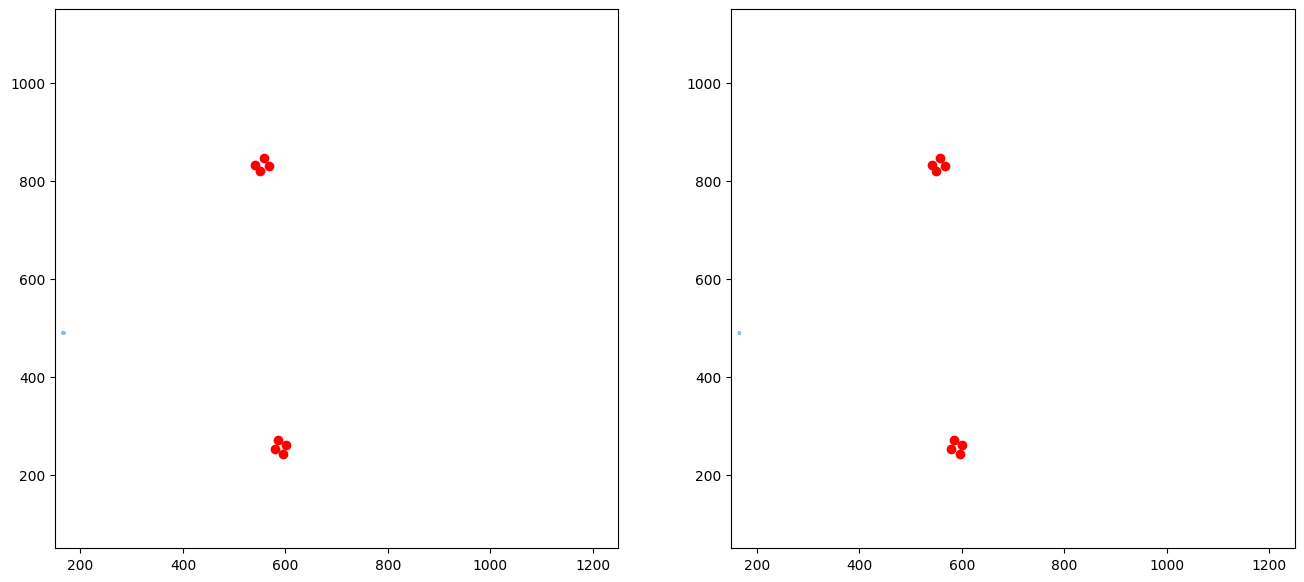

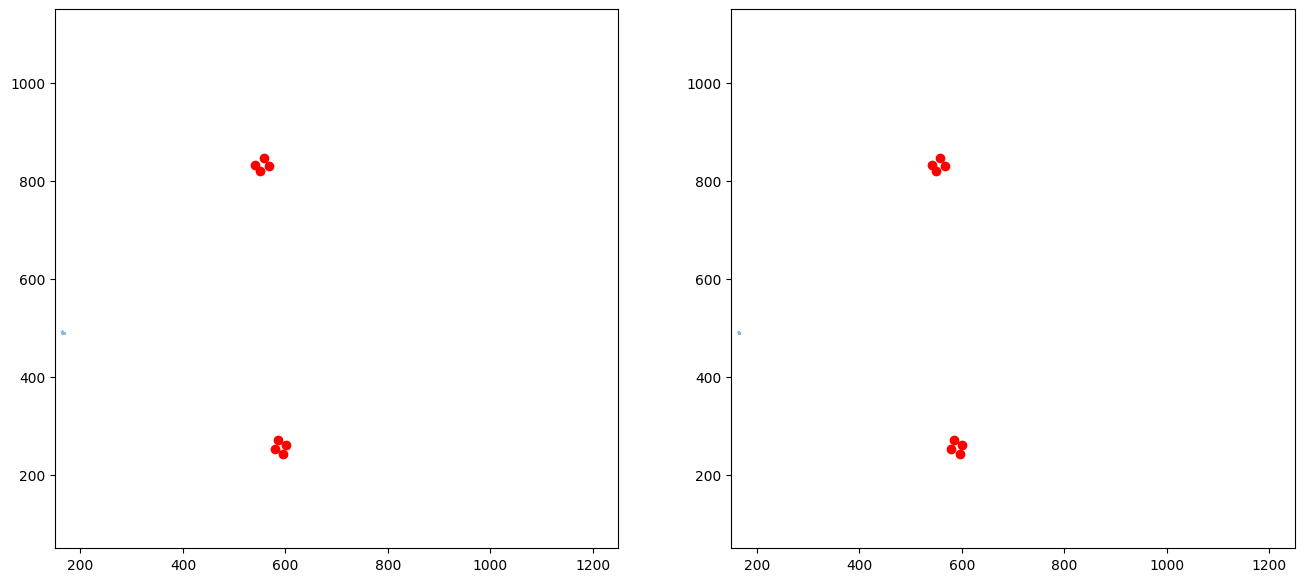

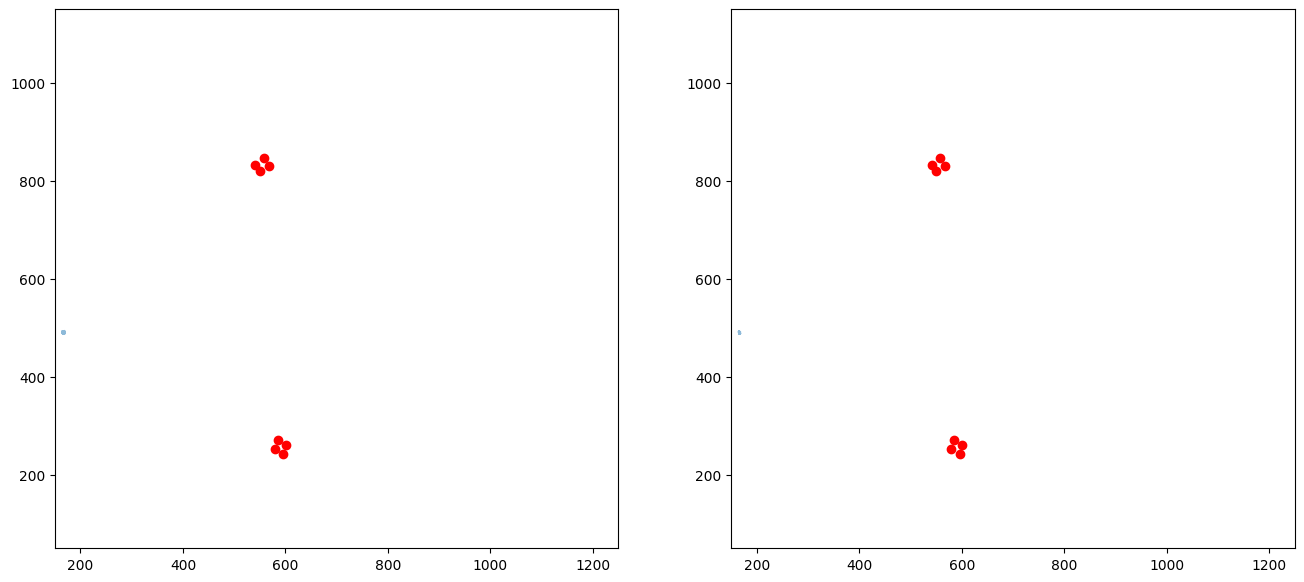

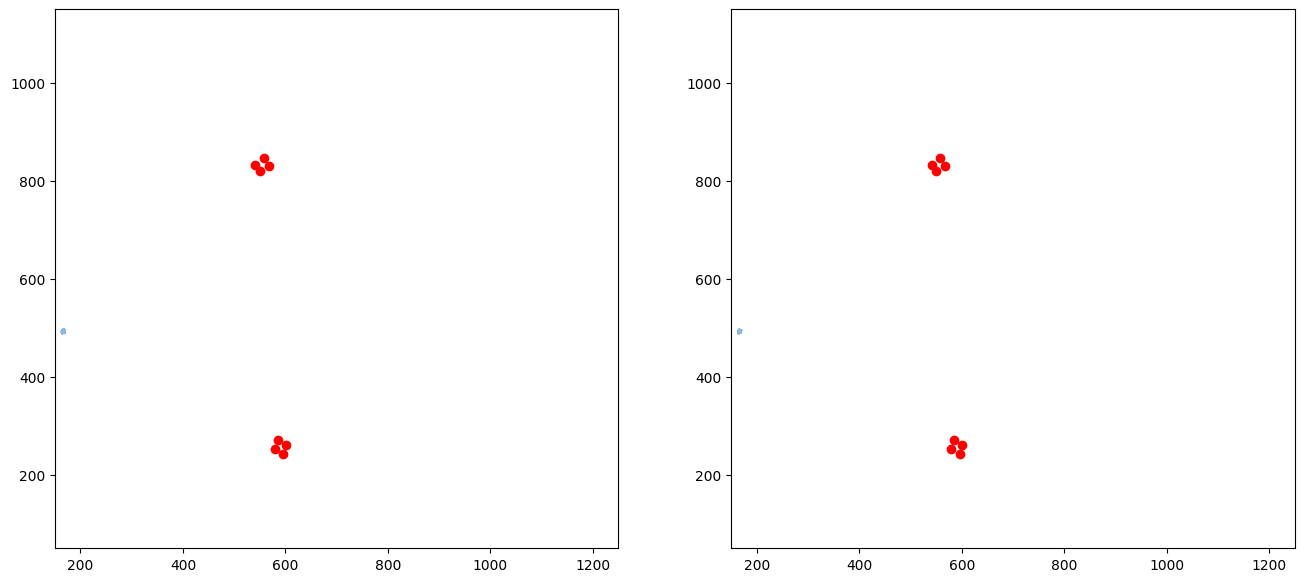

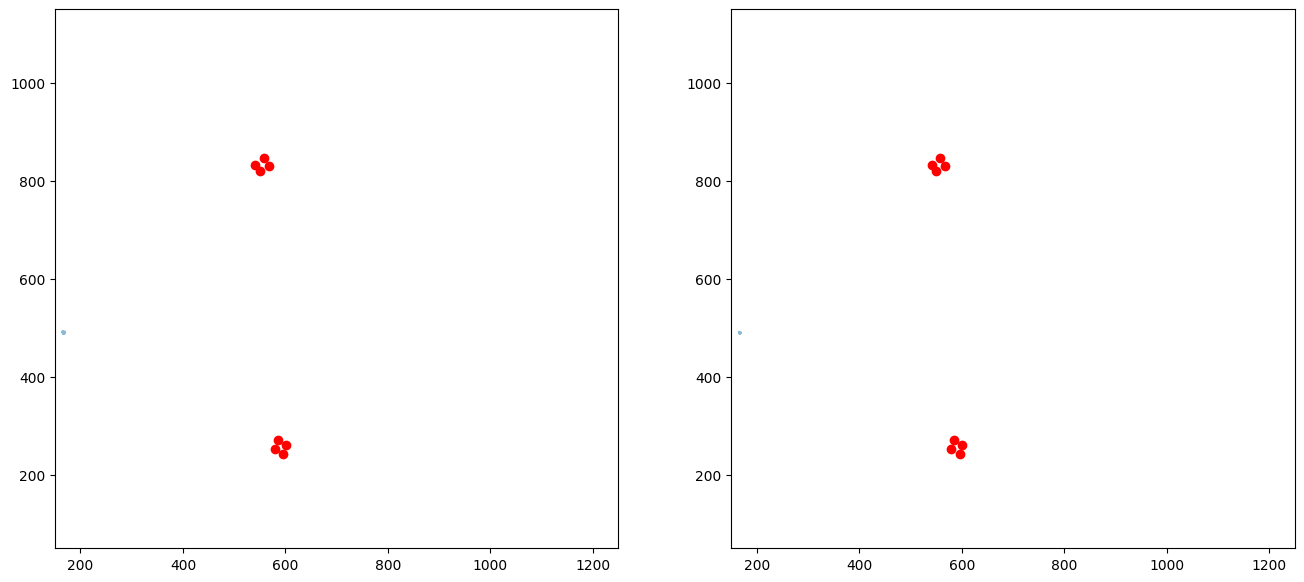

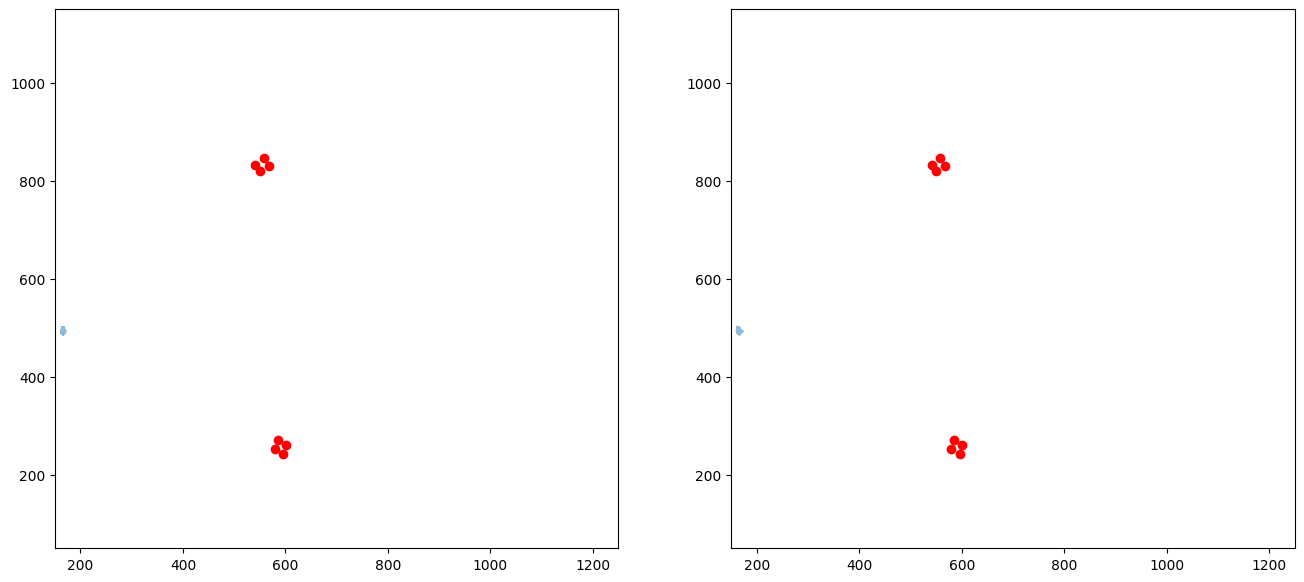

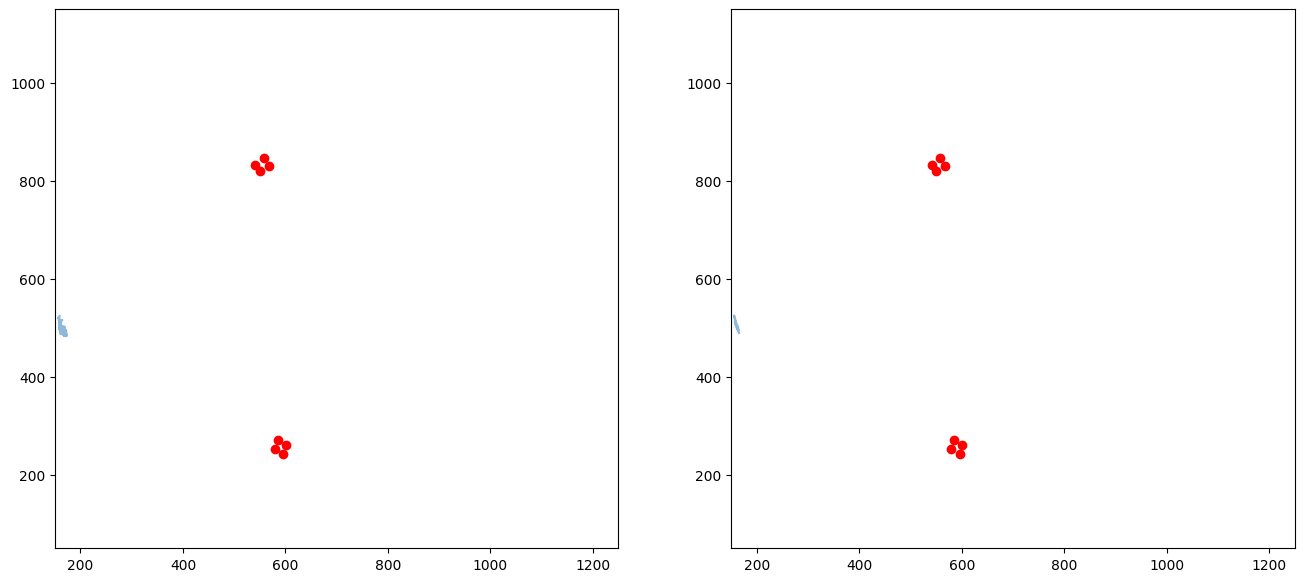

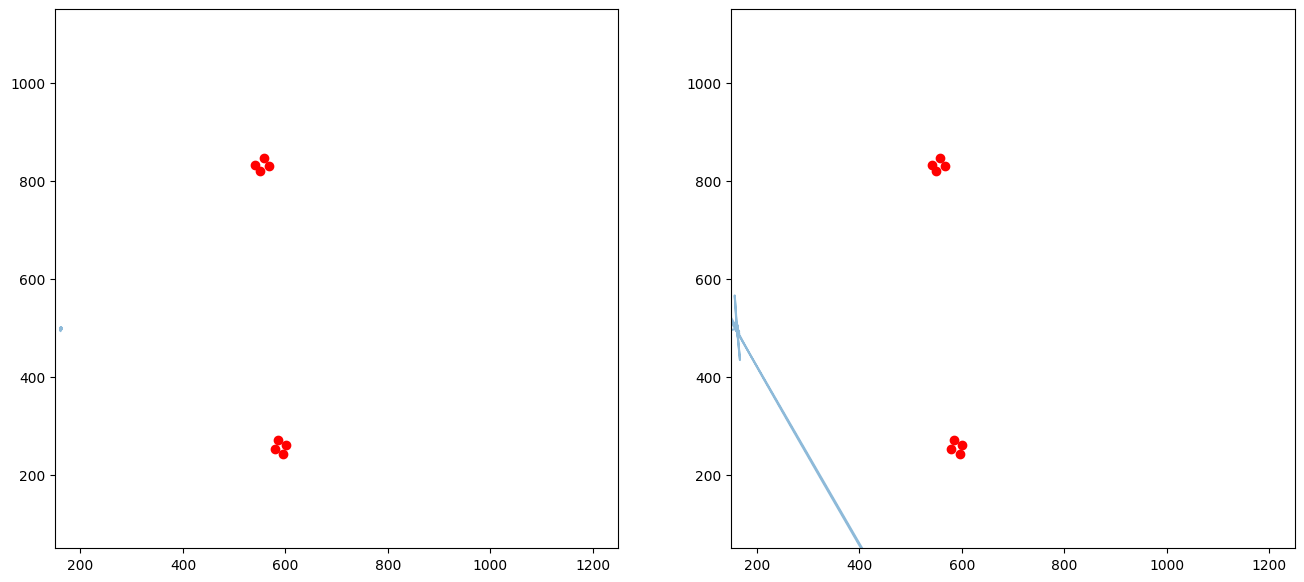

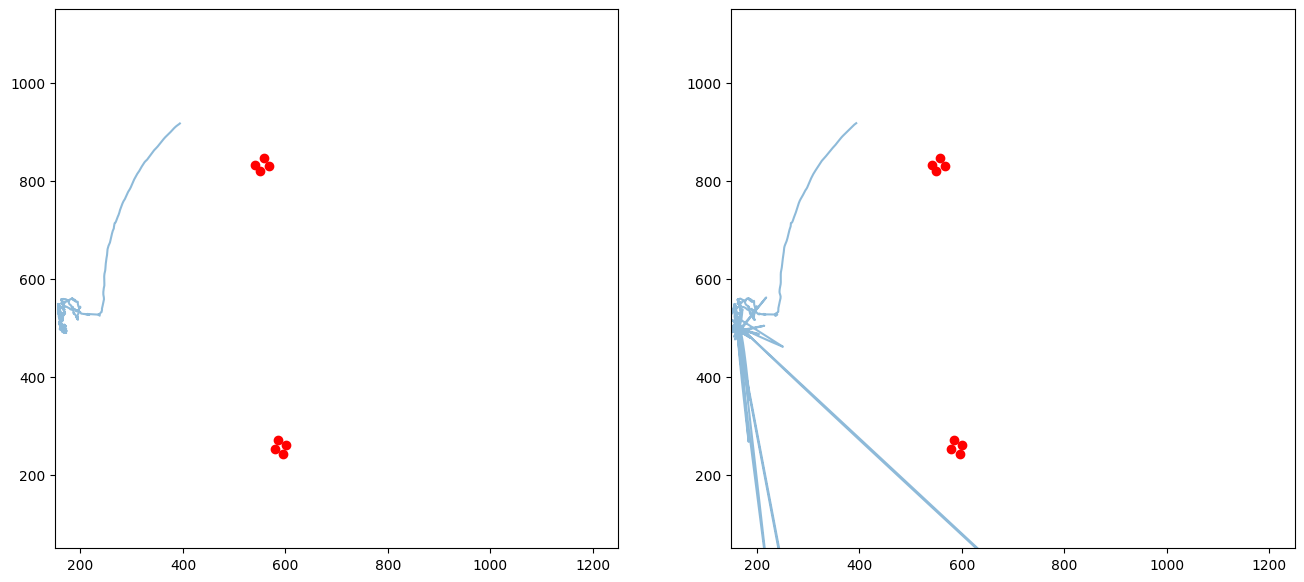

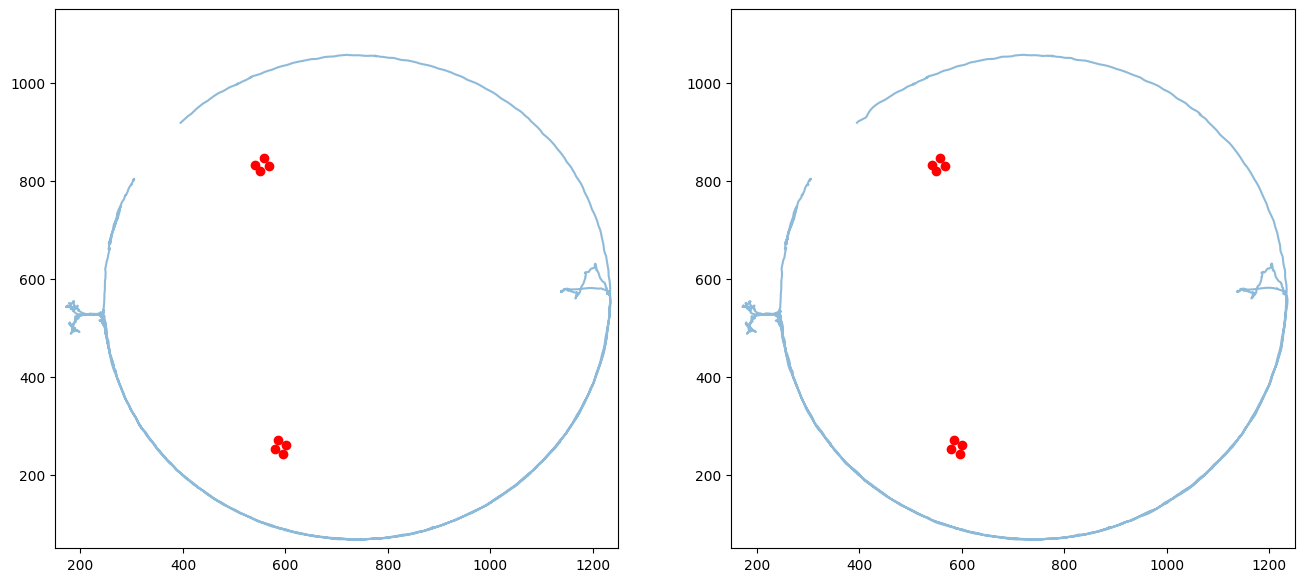

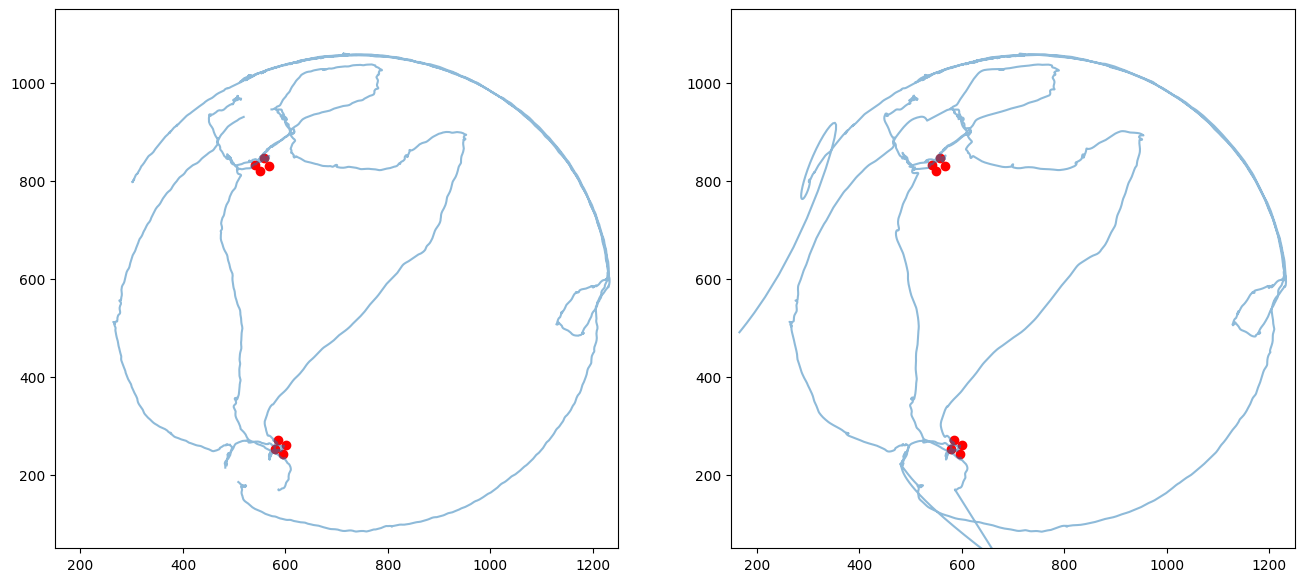

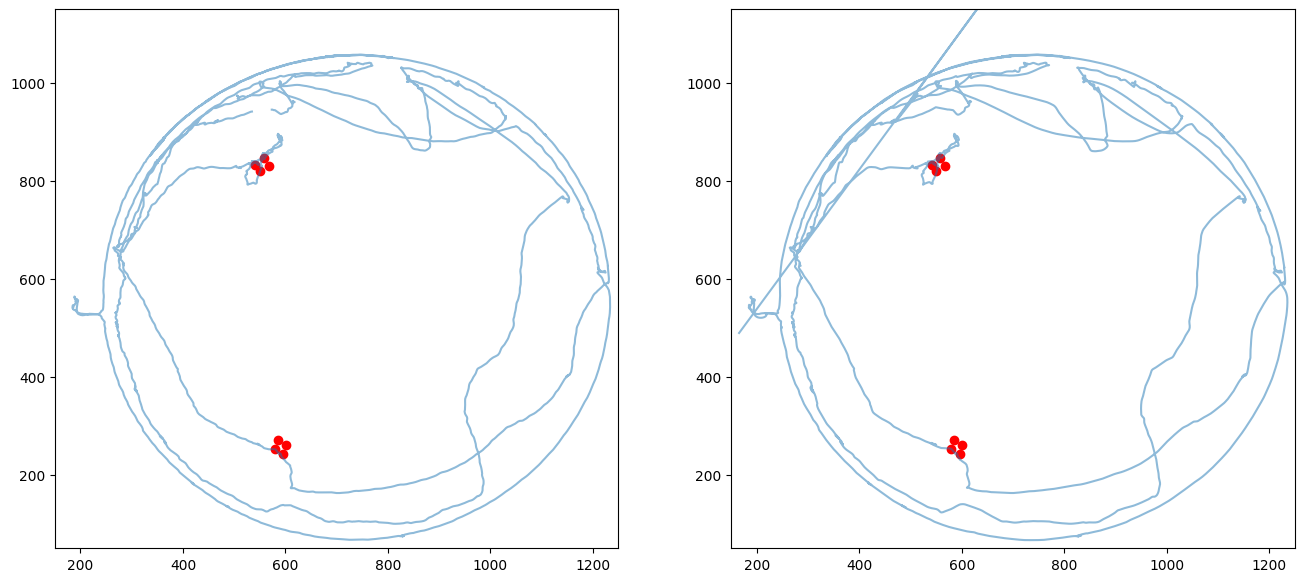

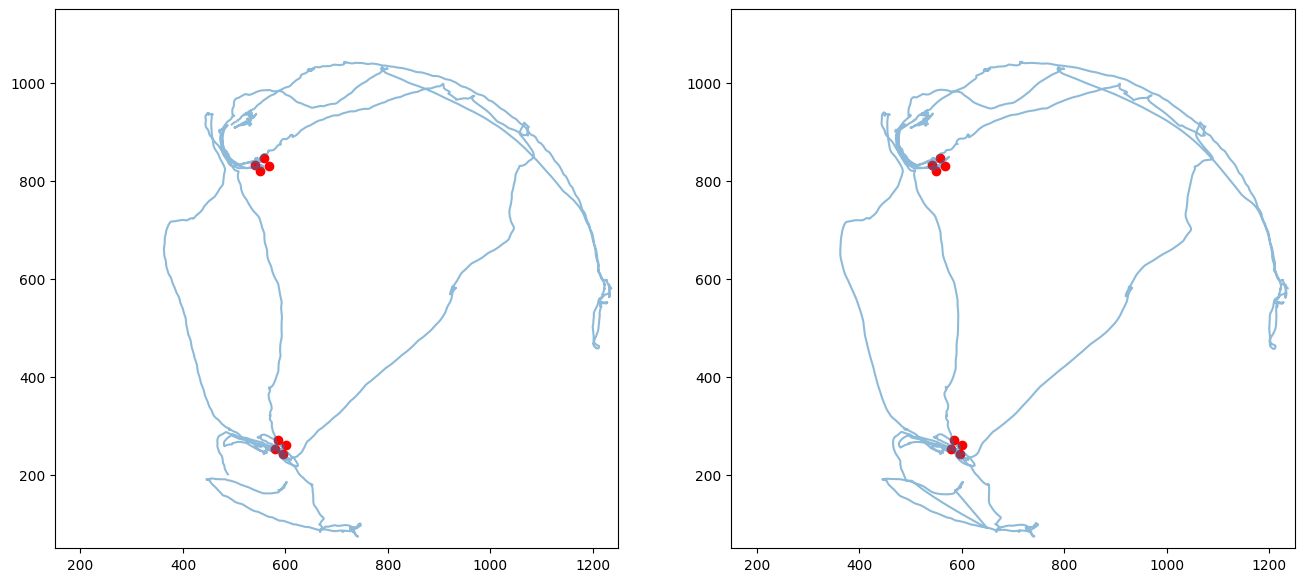

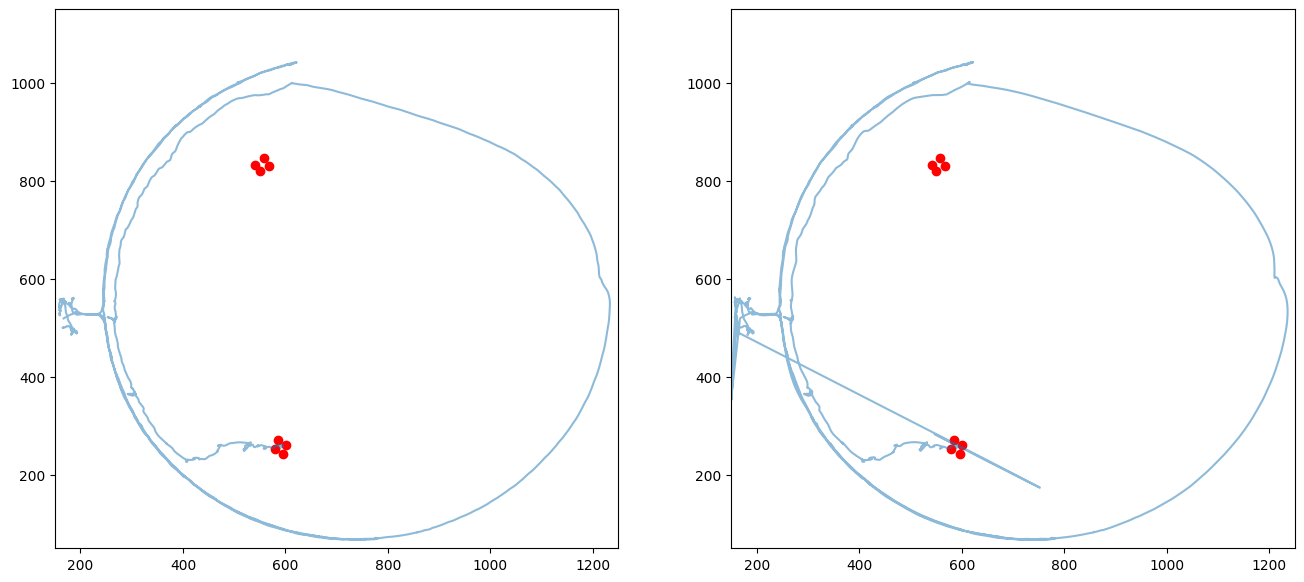

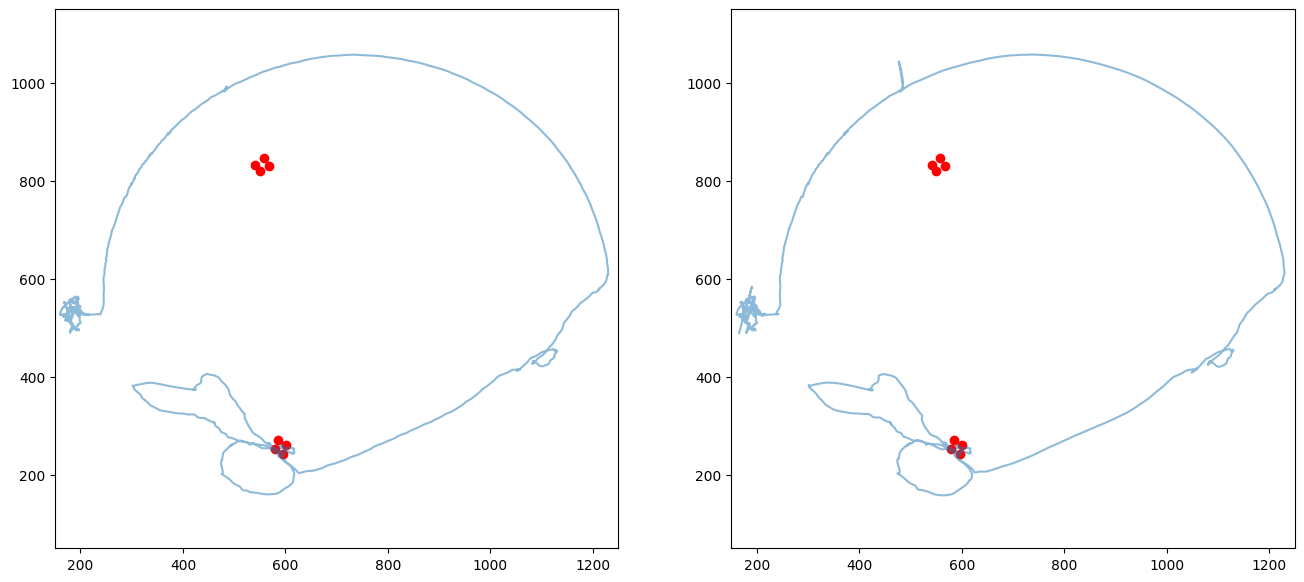

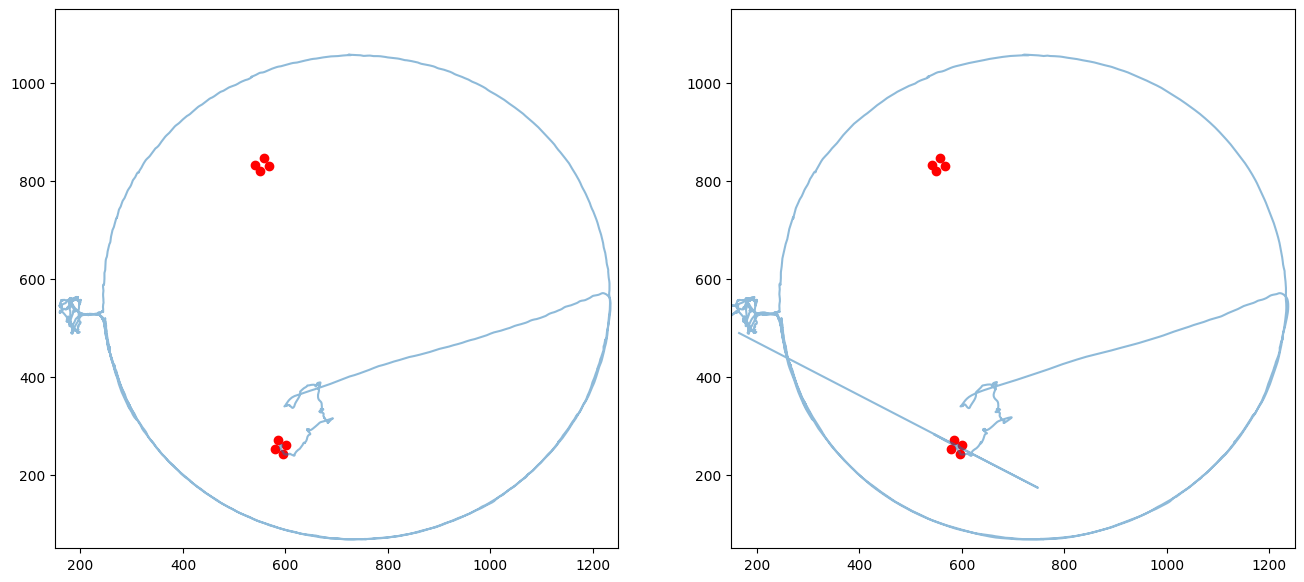

In [12]:
sessions = [6,9,10, 12]

for i in range(len(Q)):
    y = np.array(obs[:, i*10800:min((i+1)*10800, len(obs[0]))])
    #y = obs
    Q_, m0_, V0_, R_ = np.array(Q[i]), np.array([m0[i]]).T, np.array(V0[i]), np.array(R[i])
    
    onlineKF = inference.OnlineKalmanFilter(B=B, Q=Q_, m0=m0_, V0=V0_, Z=Z, R=R_)

    filtered_means = np.empty((6, 1, y.shape[1]), dtype=np.double)
    filtered_covs = np.empty((6, 6, y.shape[1]), dtype=np.double)

    for j in range(y.shape[1]):
        _, _ = onlineKF.predict()
        filtered_means[:, :, j], filtered_covs[:, :, j] = onlineKF.update(y=y[:, j])
    
    xlim, ylim = (150, 1250), (50, 1150)
    fig, axs = plt.subplots(1, 2, figsize = (16,7))
    axs[0].plot(y[0], y[1], alpha=0.5)
    axs[0].set_xlim(xlim)
    axs[0].set_ylim(ylim)
        
    filter_mean_x = filtered_means[0, 0, :]
    filter_mean_y = filtered_means[3, 0, :]
    axs[1].plot(filter_mean_x, filter_mean_y, alpha=0.5)
    
    axs[1].set_xlim(xlim)
    axs[1].set_ylim(ylim)
    
    for patch in Patch_Pos:
        patch_pos = [(int(pos['X']), int(pos['Y'])) for pos in patch]
        for pos in patch_pos: 
            axs[0].scatter(pos[0], pos[1], color = 'red')
            axs[1].scatter(pos[0], pos[1], color = 'red')
    
    plt.show()

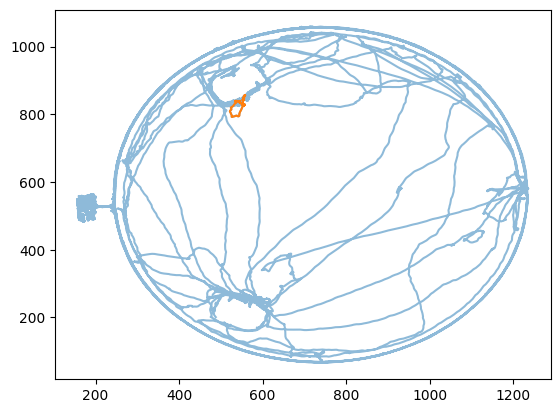

In [ ]:
'''# Overlay mouse position as trajectories around a few pellet deliveries
pellets_patch1 = api.load(root, exp02.Patch1.DeliverPellet, start=sub_start, end=sub_end)
pellets_patch1 = pellets_patch1.iloc[0:5]

fig, ax = plt.subplots(1, 1)
ax.plot(mouse_pos_sub.x, mouse_pos_sub.y, alpha=0.5)
for pellet in pellets_patch1.itertuples():
    before = pellet.Index - pd.to_timedelta(20, 's')  # get the previous 20 seconds
    path = mouse_pos_sub.loc[before:pellet.Index]   # get position data in the time before pellet delivery
    ax.plot(path.x, path.y)
plt.show()'''

# Export Videos

In [ ]:
'''# Example of exporting videos
start, end = pd.Timestamp("2022-05-26 12:25:00"), pd.Timestamp("2022-05-26 12:26:00")
video_metadata = api.load(root, exp02.CameraTop.Video, start=start, end=end)
video_metadata.index = video_metadata.index.round("20L")  # round timestamps to nearest 20 ms
frames = video.frames(video_metadata)  # get actual frames based on vid metadata
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
vid = cv2.VideoWriter("mouse_foraging.mp4", fourcc=fourcc, fps=50, frameSize=(1440, 1080))  # will save to current dir
for f in frames:  # write out frames to vid, frame-by-frame
    vid.write(f)
vid.release()'''